## 特徴量の正規化・スケーリング・データクレンジング

In [83]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# データ保存先
DATA_DIR = "./data/"

# 特徴量データとラベルデータをロード
features_path = os.path.join(DATA_DIR, "features.npy")
labels_path = os.path.join(DATA_DIR, "labels.npy")  # ← ラベルデータのパス

features = np.load(features_path)  # ← 特徴量データを読み込む
labels = np.load(labels_path)  # ← ラベルデータを読み込む

# 特徴量をDataFrameに変換（MFCCを想定）
feature_names = [f"MFCC{i+1}" for i in range(features.shape[1])]
df_features = pd.DataFrame(features, columns=feature_names)

#### 以下の処理を実施
外れ値の処理（IQRによる外れ値除去）

各特徴量の四分位範囲（IQR）を計算し、外れ値（1.5IQRを超えるデータ）を削除。
これにより、極端な値が影響を及ぼさないようにする。
スケーリングと正規化（StandardScaler）

平均0、標準偏差1となるように特徴量を変換（Zスコア標準化）。
これによって、すべての特徴量が共通のスケールで扱えるようになり、学習時の効率が向上。

### 外れ値の処理（IQRによる外れ値除去）

In [75]:
# 外れ値の処理（IQRによる外れ値除去）
Q1 = df_features.quantile(0.25)
Q3 = df_features.quantile(0.75)
IQR = Q3 - Q1
threshold = 1.5

# 外れ値除去前のデータ数を記録
original_size = df_features.shape[0]

# 外れ値除去を適用
filtered_df = df_features[~((df_features < (Q1 - threshold * IQR)) | (df_features > (Q3 + threshold * IQR))).any(axis=1)]

# 外れ値除去後のデータ数を記録
filtered_size = filtered_df.shape[0]

# 外れ値除去の影響を表示
print(f"📉 外れ値除去: {original_size} → {filtered_size} (削除数: {original_size - filtered_size})")


📉 外れ値除去: 38546 → 33797 (削除数: 4749)


### スケーリングと正規化

In [76]:
# スケーリングと正規化
scaler = StandardScaler()   
scaled_features = scaler.fit_transform(filtered_df)
df_scaled = pd.DataFrame(scaled_features, columns=feature_names)

# スケーリング後の統計情報
stats_summary = pd.concat([
    df_scaled.mean().round(2).rename("平均"),
    df_scaled.std().round(2).rename("標準偏差")
], axis=1)

# 結果を表示
print("\nスケーリング後の特徴量の統計情報\n")
print(stats_summary)


スケーリング後の特徴量の統計情報

         平均  標準偏差
MFCC1  -0.0   1.0
MFCC2  -0.0   1.0
MFCC3  -0.0   1.0
MFCC4  -0.0   1.0
MFCC5   0.0   1.0
MFCC6   0.0   1.0
MFCC7   0.0   1.0
MFCC8   0.0   1.0
MFCC9   0.0   1.0
MFCC10  0.0   1.0
MFCC11  0.0   1.0
MFCC12 -0.0   1.0
MFCC13  0.0   1.0


<Figure size 1200x800 with 0 Axes>

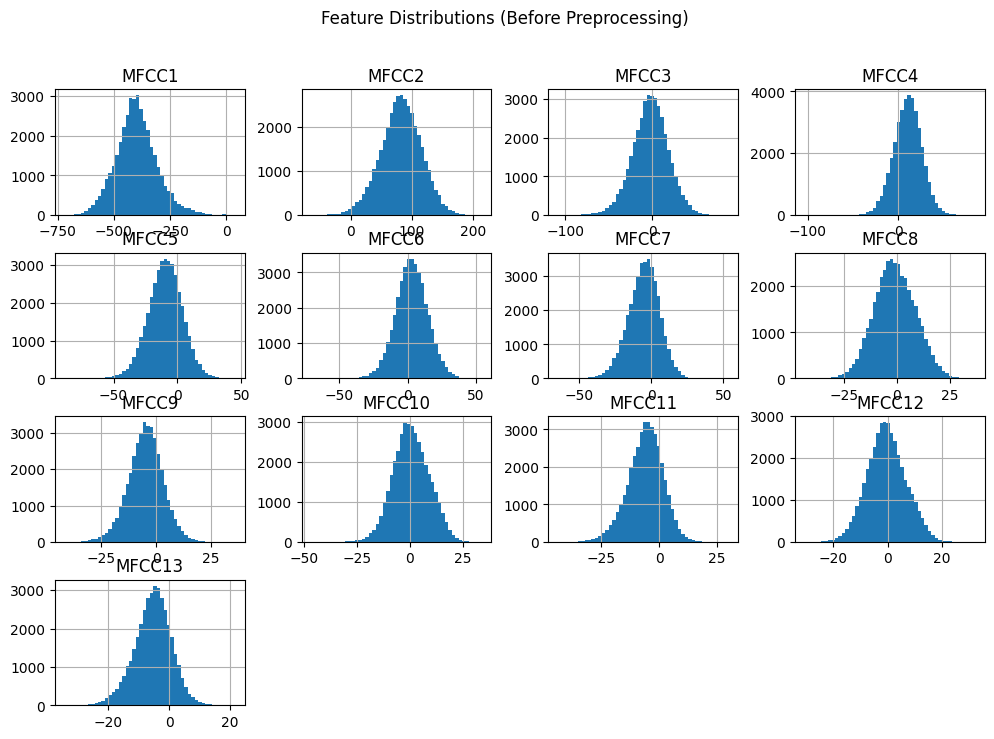

<Figure size 1200x800 with 0 Axes>

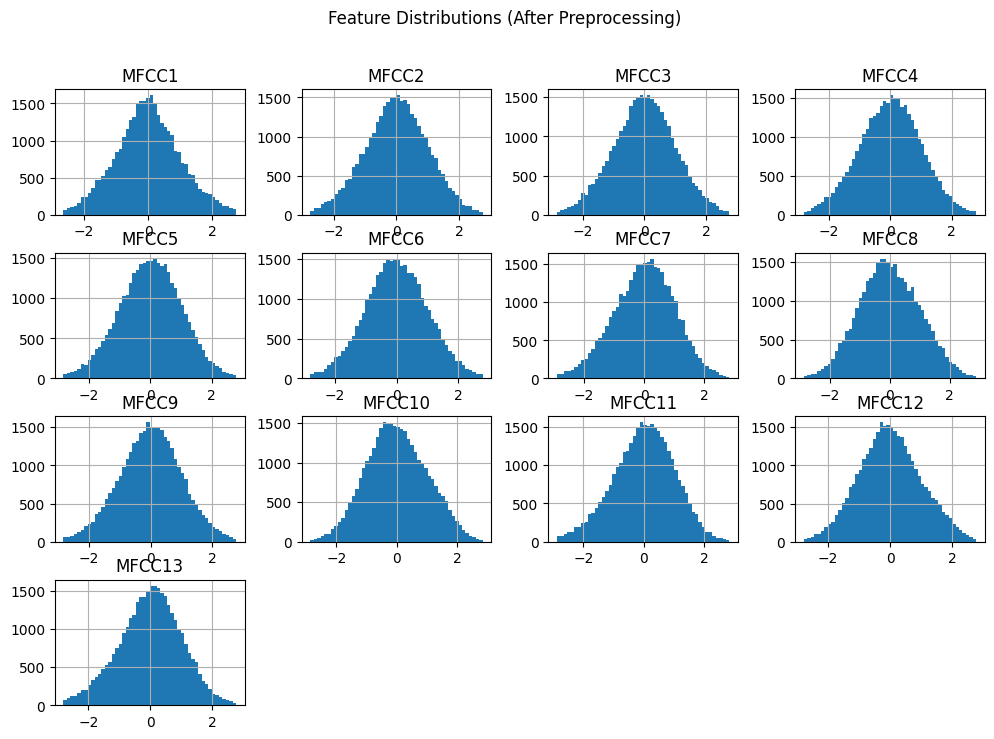

In [84]:
# 改善前のデータ分布を可視化
plt.figure(figsize=(12, 8))
df_features.hist(bins=50, figsize=(12, 8))
plt.suptitle("Feature Distributions (Before Preprocessing)")
plt.show()

# 改善後のデータ分布を可視化
plt.figure(figsize=(12, 8))
df_scaled.hist(bins=50, figsize=(12, 8))
plt.suptitle("Feature Distributions (After Preprocessing)")
plt.show()

In [78]:
from tabulate import tabulate

# 改善前後の統計情報を比較
comparison_df = pd.DataFrame({
    "特徴量": df_features.columns,
    "平均 (前処理前)": df_features.mean().round(2),
    "標準偏差 (前処理前)": df_features.std().round(2),
    "平均 (前処理後)": df_scaled.mean().round(2),
    "標準偏差 (前処理後)": df_scaled.std().round(2)
})

# 表形式で出力
print("\n📊 特徴量の統計情報（前処理前 → 前処理後）\n")
print(tabulate(comparison_df, headers="keys", tablefmt="pretty", showindex=False))


📊 特徴量の統計情報（前処理前 → 前処理後）

+--------+---------------------+---------------------+-----------------+---------------------+
| 特徴量 |   平均 (前処理前)   | 標準偏差 (前処理前) | 平均 (前処理後) | 標準偏差 (前処理後) |
+--------+---------------------+---------------------+-----------------+---------------------+
| MFCC1  | -398.54998779296875 |  90.58000183105469  |      -0.0       |         1.0         |
| MFCC2  |  82.16000366210938  |  33.0099983215332   |      -0.0       |         1.0         |
| MFCC3  | -2.3499999046325684 | 20.600000381469727  |      -0.0       |         1.0         |
| MFCC4  | 10.550000190734863  |  15.40999984741211  |      -0.0       |         1.0         |
| MFCC5  |  -9.5600004196167   | 13.390000343322754  |       0.0       |         1.0         |
| MFCC6  |  3.009999990463257  | 11.859999656677246  |       0.0       |         1.0         |
| MFCC7  | -5.150000095367432  |  10.84000015258789  |       0.0       |         1.0         |
| MFCC8  | -0.9100000262260437 |  9.720000267028809  | 

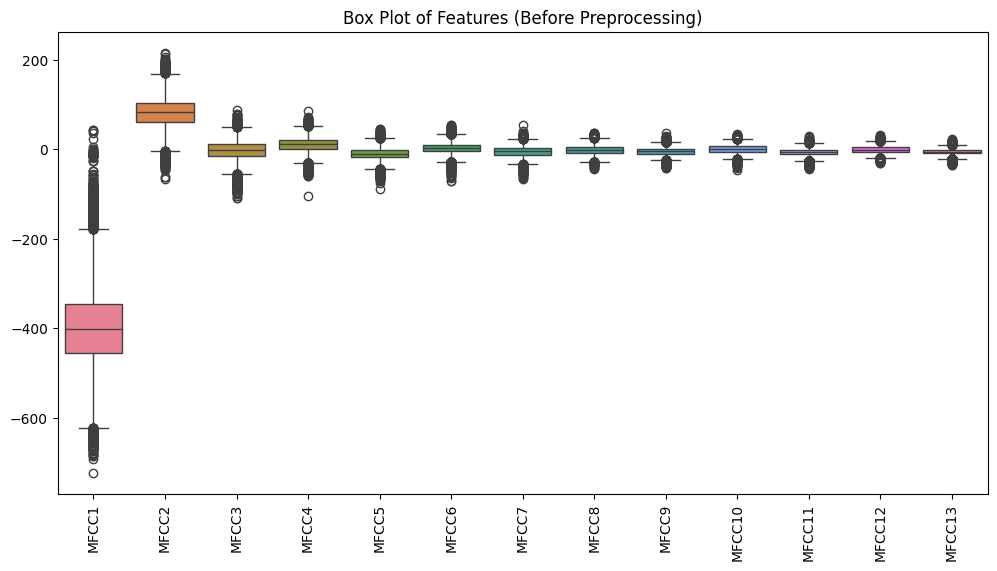

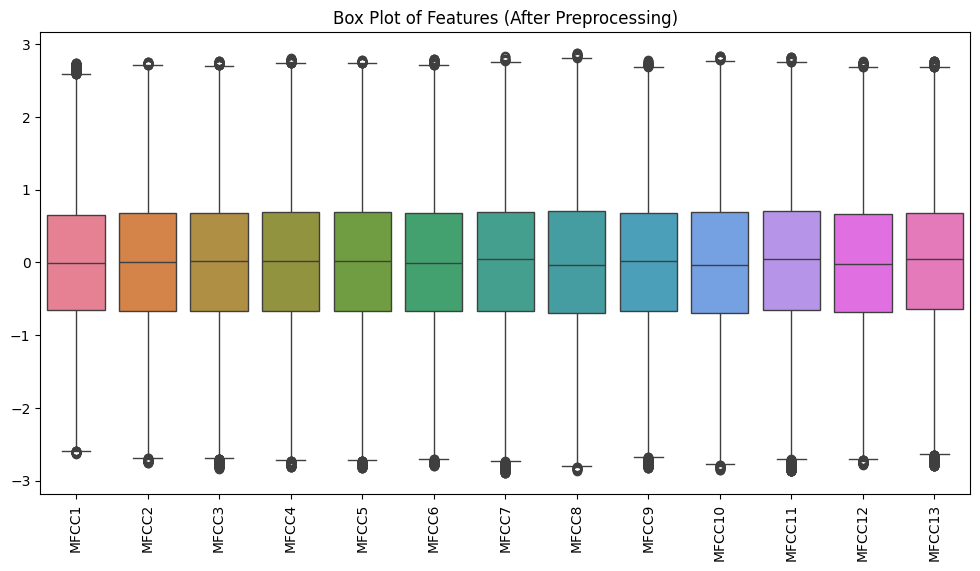

In [79]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_features)
plt.xticks(rotation=90)
plt.title("Box Plot of Features (Before Preprocessing)")
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_scaled)
plt.xticks(rotation=90)
plt.title("Box Plot of Features (After Preprocessing)")
plt.show()

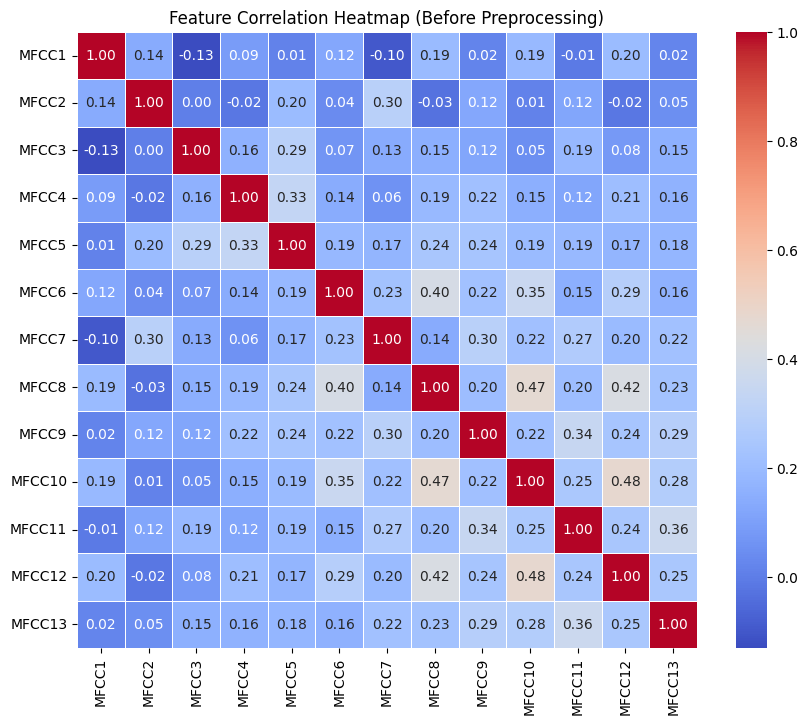

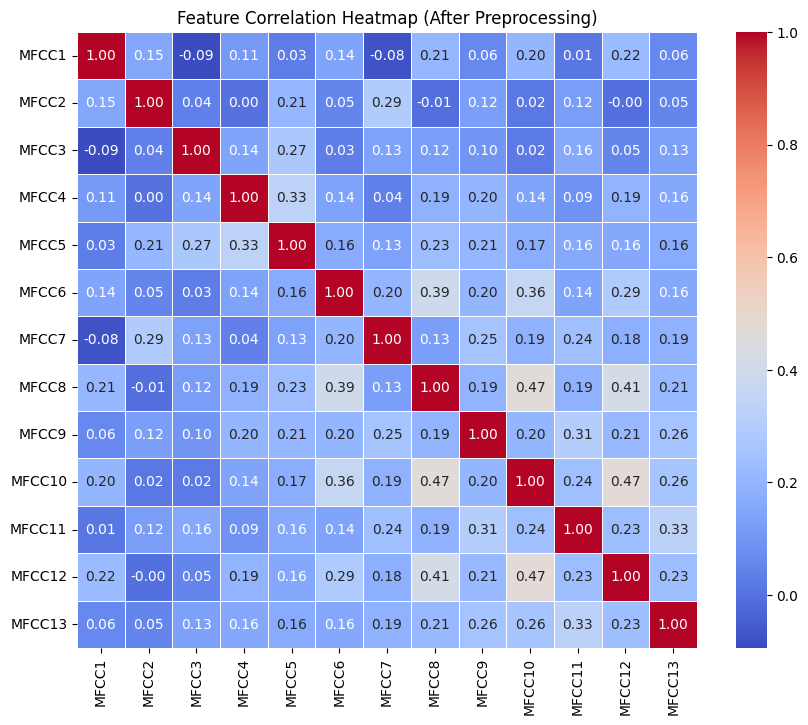

In [86]:
# 特徴量間の相関関係の比較
plt.figure(figsize=(10, 8))
sns.heatmap(df_features.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap (Before Preprocessing)")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(df_scaled.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap (After Preprocessing)")
plt.show()

In [82]:
# 外れ値除去を適用したときにラベルも合わせる
features = np.load(features_path)
labels = np.load(labels_path)  # ← y を適切にロード

# データのフィルタリング後のインデックスを取得
filtered_indices = filtered_df.index

# フィルタ後の特徴量と対応するラベルを取得
filtered_features = filtered_df.to_numpy()
filtered_labels = labels[filtered_indices]

# 特徴量とラベルの整合性をチェック
if len(filtered_features) != len(filtered_labels):
    raise ValueError(f"❌ データ数の不一致: 特徴量 {len(filtered_features)}, ラベル {len(filtered_labels)}")

# 特徴量とラベルを保存
np.save(os.path.join(DATA_DIR, "processed_features.npy"), filtered_features)
np.save(os.path.join(DATA_DIR, "processed_labels.npy"), filtered_labels)

print(f"✅ 特徴量とラベルの保存が完了しました！")
print(f"📁 保存先: processed_features.npy ({filtered_features.shape})")
print(f"📁 保存先: processed_labels.npy ({filtered_labels.shape})")


✅ 特徴量とラベルの保存が完了しました！
📁 保存先: processed_features.npy ((33797, 13))
📁 保存先: processed_labels.npy ((33797,))
